# Fast scientific code with Python


Authors: [Pierre Ablin](https://www.pierreablin.com), Antoine Tavant. 


Based on an idea by [Alexandre Gramfort](http://alexandre.gramfort.net/).





**Dependencies:**

For this notebook, we will need **numba, cython, numexpr, memory_profiler and line_profiler**. numba evolves quickly, so the most recent version is the best. To install all those:

` $ pip install ...`



To get the latest versions, running anaconda:

` $ conda update ...`





Python is the go-to langage when it comes to quickly translating an idea into code. It is very easy to write and read. The drawback is that most natural operations come with a lot of tests, conversion, type checking, etc... which renders scientific coding with the standard python library extremely slow. Luckily, there are a lot of tools and libraries to make Python code almost a fast as native fortran/C in most cases.

### Is Python truly slow? 
Not if well optimized. Take the `scikit-learn` library, which contains many machine learning algorithms. It is written in Python, yet it contains the fastest implementation available of several massively used algorithms.

As a side note: a great way to produce a scientific code in Python is first to write a working algorithm that might be slow. The important part is that it works. Then, profile it (i.e. time each of its component, or check the memory load if thats a problem too) to see which part can be improved and which part does not really have to be changed. It sounds obvious, but it is almost always useless to try to optimize a function that only makes for 5% of the total timing of the algorithm.


With that in mind, parts of the algorithms that are not critical can be left in beautiful and clean python code while the rest has to be optimized.



### Test Case
Let us try to solve a simple problem. Consider the Wallis product:
$$P_n = 2 \prod_{i=1}^{n}\frac{4i^2}{4i^2 - 1}$$ which converges to $\pi$. We are going to try to make its computation as fast as possible for large $n$.

A very naive approach is the following:

In [1]:
def wallis1(n):
    out = 2.
    for i in range(1, n):
        out *= float((4 * i ** 2)) / float((4 * i ** 2 - 1))
    return out

wallis1(10000)

3.1415141108281714

## Vectorize
The previous method is slow, because of the loop. The operations carried inside the loop are extremely slow and repeated many times.
The most natural way to overcome this problem in python is to vectorize using numpy.

In [2]:
import numpy as np

def wallis2(n):
    int_list = np.arange(1, n)
    return 2 * np.prod( 4 * int_list ** 2 / (4 * int_list ** 2 - 1.))


%timeit wallis1(10000)  # Python loop
%timeit wallis2(10000)  # Vectorized with Numpy

100 loops, best of 3: 3.82 ms per loop
The slowest run took 5.00 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 81.4 µs per loop


We can see that this code is orders of magnitude faster than the previous one. Vectorizing is extremely important in scientific computing as vectors/matrices/tensors are by far the most common data structure encountered. Consequently, some very efficient libraries exist to work with vectors. This explains why numpy is at the core of scientific computing.

Now, we can make this code faster by avoiding useless computations. Indeed, the product `4 * int_list ** 2` only has to be computed once.

In [4]:
def wallis3(n):
    tmp = 4 * np.arange(1, n) ** 2
    return 2 * np.prod( tmp / (tmp - 1.))

%timeit wallis2(10000)  # Vectorized
%timeit wallis3(10000)  # Vectorized without unecessary computations

10000 loops, best of 3: 81.6 µs per loop
10000 loops, best of 3: 66.4 µs per loop


Another gain factor comes from the useless memory copies performed in the above call. Once `int_list` is computed, there is no need to keep it in memory. Further, when doing `tmp = 4 * int_list ** 2`, numpy takes int_list, creates an intermediate copy, then squares it. Then it takes that copy, and multiplies it by 4. These copies are unecessary. The way to efficiently manage memory and avoid unecessary copies is to use `+=`, `-=`, etc... You should also avoid as much as possible type conversion.

There is another "trick" to speed up the computations here. In the previous algorithm, the operation `tmp / (tmp - 1.)` takes much longer than, for instance, dividing the vector `tmp` by a constant, because for each index of the array numpy has to grab an element from `tmp` and an element from `tmp - 1.`. Furthermore, there is no simple way to perform this operation without having to momentarily store a copy of `tmp - 1.`. Luckily, for this problem, we can rewrite $$\frac{4 i^2}{4 i^2 - 1} = 1 + \frac{1}{4 i^2 - 1}$$
That kind of expression allows for a streamlined sequence of copyless operations, with only scalar - list operations and not list - list.

In [5]:
def wallis4(n):
    tmp = np.arange(1, n, dtype=float)  # Use float instead of integer to avoid type conversion
    tmp *= tmp  # Legend has it that it is the fastest way to square
    tmp *= 4.
    tmp -= 1.
    np.reciprocal(tmp, out=tmp)
    tmp += 1.
    return 2. * np.prod(tmp)

%timeit wallis3(10000)  # Vectorized without unecessary computations
%timeit wallis4(10000)  # Vectorized with in place computations

10000 loops, best of 3: 66 µs per loop
10000 loops, best of 3: 45 µs per loop


We have gained a little bit (a factor two compared to the naive numpy version). In order to precisely see where time is consumed, we can use a *line profiler*:

In [ ]:
%load_ext line_profiler

The syntax to run it in ipython is: `%lprun -f function_name code_to_execute`, where `function_name` is the function that you want to profile during the execution of `code_to_execute`.

In [6]:
%lprun -f wallis4 wallis4(1000000)

Observe that the most consuming task for a large $N$ is to simply compute the initial array...

## Cython

Now, it is not always the case that operations can be vectorized as easily. Sometimes you just cannot avoid the loops. We can use Cython to write code that is going to be compiled in C.

#### Installation :
```
pip install cython
```

Without conda, add :
```bash
sudo apt install python-dev python3-dev```

In [7]:
%load_ext cython
# Load Cython on jupyter to use it with %%magic

In cython, you have to type and define each variable that you are going to use beforehand, which is going to render our code a bit less readable. If cython does not understand an instruction, it will fall back to a python instruction, which might render everything incredibly slow. To debug, you can use the command --annotate which will hilight the lines which interact wit python (yellow inside of a loop means slow).

In [8]:
%%cython
import cython

@cython.cdivision(True)
def wallis5(int n):
    cdef double out = 2.
    cdef double tmp = 0.
    cdef int i
    for i in range(1, n):
        tmp = 4. * (i * i)
        out *= tmp / (tmp - 1.)
    return out

In [9]:
%timeit wallis4(10000)  # Best vectorized with Numpy
%timeit wallis5(10000)  # Raw loop in Cython

The slowest run took 4.21 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 44.7 µs per loop
100000 loops, best of 3: 12.7 µs per loop


Cython is more efficient than numpy for this problem.

An important advantage of the cython implementation is its memory load!
To have a quick check at the memory load of a program, we can use `memory_profiler`.

In [10]:
%load_ext memory_profiler

In [11]:
%memit wallis4(1000000)  # Best vectorized with Numpy
%memit wallis5(1000000)  # Raw loop in Cython

peak memory: 67.60 MiB, increment: 0.15 MiB
peak memory: 67.61 MiB, increment: 0.01 MiB


Cython basically allows you to do most things you would want to do in C, and supports most functions of the standard library. 

## Numba

Now, there is an incredible tool called Numba which is getting better and better, and aims at accelerating the code even more than Cython, without having these anoying variable declarations on top of the program. Using it is super easy: you take your naive approach, put @autojit on top and voilà.

In [12]:
from numba import autojit


@autojit
def wallis6(n):
    out = 2.
    for i in range(1, n):
        tmp = 4 * i**2
        out *= tmp / (tmp - 1.)
    return out

%timeit wallis4(10000)  # Best vectorized with Numpy
%timeit wallis6(10000)  # Raw Numba loop

10000 loops, best of 3: 45.9 µs per loop
The slowest run took 6839.96 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 14 µs per loop


Now let us compare all these methods:

Timing for Numpy 1 ...
Timing for Numpy 2 ...
Timing for Numpy 3 ...
Timing for Cython ...
Timing for Numba ...


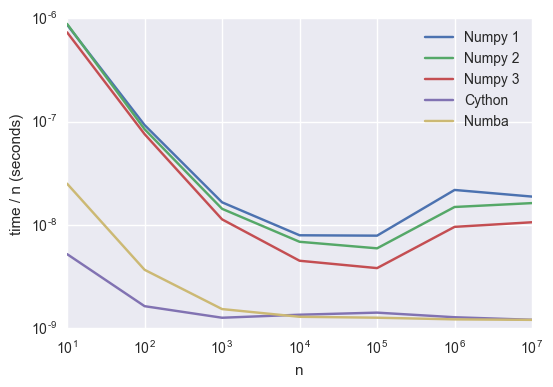

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.color_palette("colorblind")
# Use seaborn to have instantly beautiful plots !

functions = [wallis2, wallis3, wallis4, wallis5, wallis6]
names = ['Numpy 1', 'Numpy 2', 'Numpy 3', 'Cython', 'Numba']
n_list = np.logspace(1, 7, num=7, dtype=int)


plt.figure()
for function, name in zip(functions, names):
    print('Timing for %s ...' % name)
    times = []
    for n in n_list:
        t = %timeit -oq function(n)
        times.append(t.best / float(n))
    plt.loglog(n_list, times, label=name)
plt.xlabel('n')
plt.ylabel('time / n (seconds)')
plt.legend(loc='upper right')
plt.show()

The results are pretty clear, on this problem, Cython and Numba are the winners. Numba is also much easier to use but lacks some features of Cython.

# Array processing

The previous example made Numba really shine. The reality is sometimes subtler.

Let us consider the simple case of computing the mean of a function of a signal $x(t)$ of length $T$. That is, we want to compute $\frac{1}{T}\sum_{t=1}^T f(x(t))$. Let us take for $f$ a slightly complicated function: $$f(x) = \cos(e^{- \rvert x \lvert })$$


### Numpy

In [14]:
def function1(x):
    """Standard array processing with numpy"""
    return np.mean(np.cos(np.exp(-np.abs(x))))

def function2(x):
    """Better array processing with numpy, limited number of copies"""
    tmp = np.abs(x)
    tmp *= -1.
    np.exp(tmp, out=tmp)
    np.cos(tmp, out=tmp)
    return np.mean(tmp)

### Cython

In [15]:
%%cython
from libc.math cimport exp, cos

def function3(double[:] x):
    """Array processing with Cython"""
    cdef double out = 0.
    cdef int T = x.shape[0]
    cdef int i
    for i in range(T):
        out += cos(exp(-abs(x[i])))
    return out / float(T)


### Numba

In [16]:
@autojit(nopython=True)
def function4(x):
    """Array processing with numba"""
    out = 0.
    T = x.shape[0]
    for i in range(x.shape[0]):
        out += np.cos(np.exp(-np.abs(x[i])))
    return out / float(T)

### Numexpr

Numexpr is a library that performs efficient expression evaluation. It is really great to compute complicated functions of large arrays.

In [17]:
import numexpr as ne

def function5(x):
    """Array processing using NumExpr"""
    tmp = ne.evaluate('cos(exp(-abs(x)))')
    return np.mean(tmp)

def function6(x):
    return ne.evaluate('sum(cos(exp(-abs(x))))') / float(len(x))

### Comparison

Timing for Numpy ...
Timing for Numpy2 ...
Timing for Cython ...
Timing for Numba ...
Timing for Numexpr ...
Timing for Numexpr2 ...


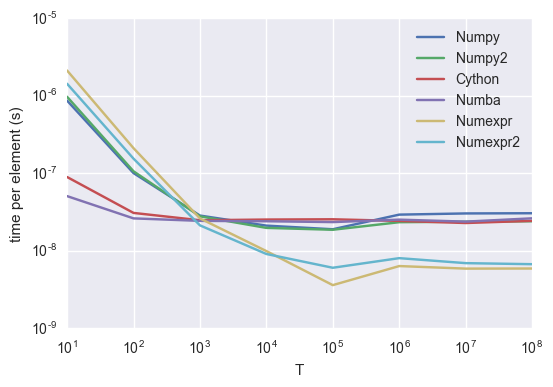

In [18]:
functions = [function1, function2, function3, function4, function5, function6]
names = ['Numpy', 'Numpy2', 'Cython', 'Numba', 'Numexpr', 'Numexpr2']
T_list = np.logspace(1, 8, num=8, dtype=int)
x_list = [np.random.randn(T) for T in T_list]

plt.figure()
for function, name in zip(functions, names):
    print('Timing for %s ...' % name)
    times = []
    for x, T in zip(x_list, T_list):
        t = %timeit -oq function(x)
        times.append(t.best / float(T))
    plt.loglog(T_list, times, label=name)
plt.xlabel('T')
plt.ylabel('time per element (s)')
plt.legend(loc='upper right')
plt.show()

Numexpr is generally the go-to tool when it comes to large array processing. Unfortunately, the built in 'sum' function is not as fast as expected, it does not use parallelization, which explains why using `np.mean` is faster for large T.